# Part II – Explanatory Data Visualization (Prosper Loans)
_Udacity: Data Analysis Final Project_

**Author:** Reema Kusa  
**Date:** 2025-11-11

This notebook turns insights from Part I into **polished** visuals with clear commentary. Overarching question:

> **ما العوامل الأكثر تأثيرًا على معدل فائدة المقترض BorrowerRate، وكيف يتداخل تقييم ProsperRating مع مبلغ القرض ونِسَب الدين؟**

## 1. Load & minimal prep

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(context="talk", style="white")

# Locate dataset
DATA_PATHS = [
    Path('prosperLoanData.csv'),
    Path('data/prosperLoanData.csv'),
    Path('/mnt/data/prosperLoanData.csv')
]
csv_path = None
for p in DATA_PATHS:
    if p.exists():
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError("prosperLoanData.csv not found. Place it next to this notebook and re-run.")

df = pd.read_csv(csv_path)

# Minimal selection & typing
cols = ['LoanStatus','ProsperRating (Alpha)','ProsperScore','BorrowerRate','BorrowerAPR','Term',
        'LoanOriginalAmount','StatedMonthlyIncome','DebtToIncomeRatio']
cols = [c for c in cols if c in df.columns]
df = df[cols].copy()
df.columns = [c.replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]

if 'ProsperRating_Alpha' in df.columns:
    pr_order = ['HR','E','D','C','B','A','AA']
    df['ProsperRating_Alpha'] = pd.Categorical(df['ProsperRating_Alpha'], categories=pr_order, ordered=True)


## 2. Key Insight #1 – توزيع معدل الفائدة (واللوغ لتوضيح البنية)

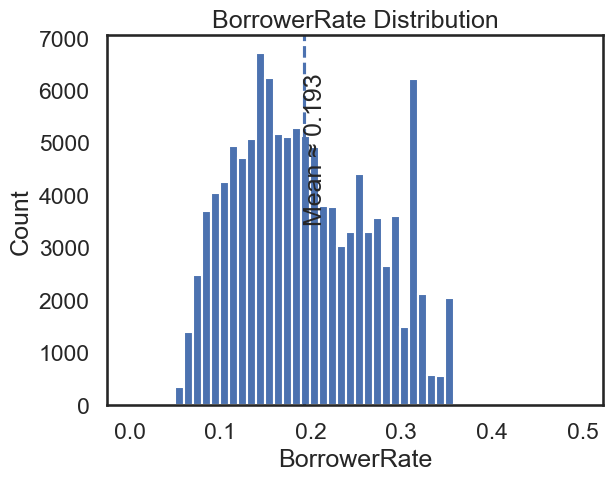

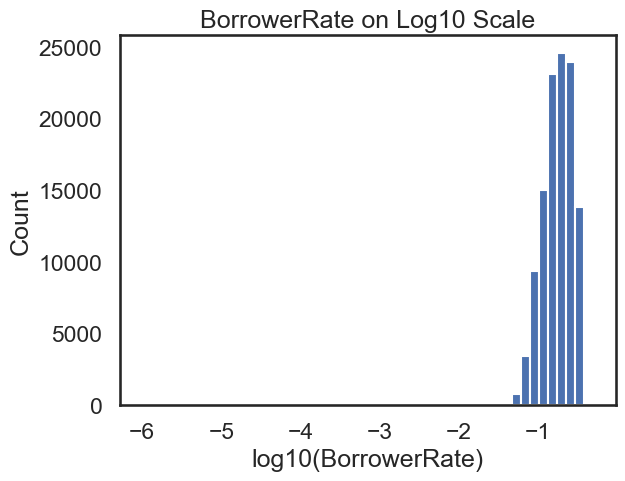

In [2]:
import numpy as np

fig = plt.figure()
plt.hist(df['BorrowerRate'].dropna(), bins=50)
plt.title("BorrowerRate Distribution")
plt.xlabel("BorrowerRate")
plt.ylabel("Count")
mean_rate = df['BorrowerRate'].mean()
plt.axvline(mean_rate, linestyle='--')
plt.text(mean_rate, plt.ylim()[1]*0.9, f"Mean ≈ {mean_rate:.3f}", rotation=90, va="top")
plt.show()

fig = plt.figure()
plt.hist(np.log10(df['BorrowerRate'].dropna()+1e-6), bins=50)
plt.title("BorrowerRate on Log10 Scale")
plt.xlabel("log10(BorrowerRate)")
plt.ylabel("Count")
plt.show()


**Takeaway:** التوزيع غير متماثل، وهناك نطاقات شائعة؛ استخدام مقياس لوغاريتمي يساعد في رؤية التفاصيل.

## 3. Key Insight #2 – ProsperRating يرفع/يخفض المعدلات عند نفس الظروف

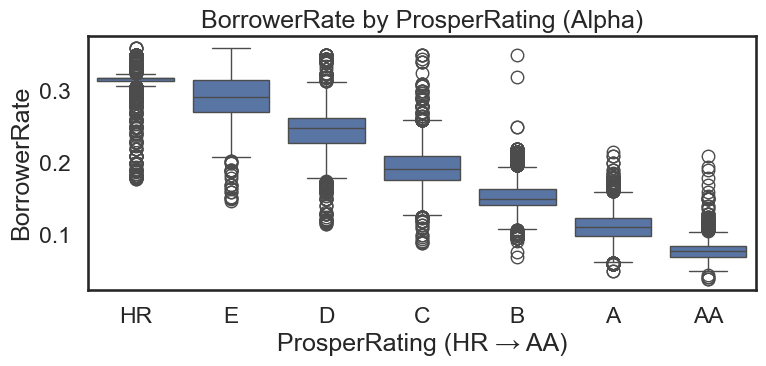

In [3]:
if 'ProsperRating_Alpha' in df.columns:
    fig = plt.figure(figsize=(8,4))
    sns.boxplot(x='ProsperRating_Alpha', y='BorrowerRate', data=df)
    plt.title("BorrowerRate by ProsperRating (Alpha)")
    plt.xlabel("ProsperRating (HR → AA)")
    plt.ylabel("BorrowerRate")
    plt.tight_layout()
    plt.show()


**Takeaway:** تقييم أفضل (من HR إلى AA) يرتبط عادةً **بانخفاض** معدل الفائدة.

## 4. Key Insight #3 – المبلغ ضد المعدل مع تفصيل التقييم (تداخل الحجم مع الجودة)

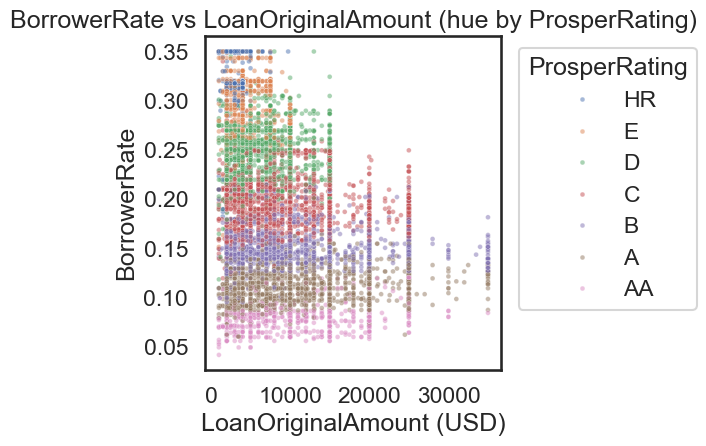

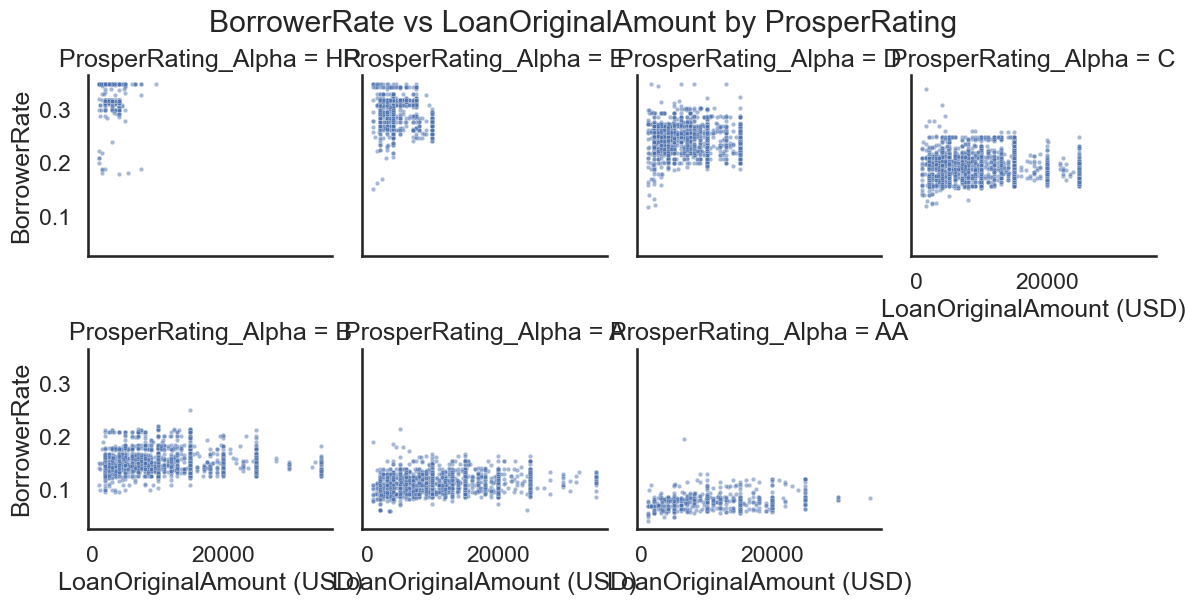

In [4]:
if 'ProsperRating_Alpha' in df.columns:
    fig = plt.figure()
    samp = df[['LoanOriginalAmount','BorrowerRate','ProsperRating_Alpha']].dropna().sample(min(10000, df.dropna().shape[0]), random_state=1)
    sns.scatterplot(data=samp, x='LoanOriginalAmount', y='BorrowerRate', hue='ProsperRating_Alpha', s=12, alpha=0.5)
    plt.title("BorrowerRate vs LoanOriginalAmount (hue by ProsperRating)")
    plt.xlabel("LoanOriginalAmount (USD)")
    plt.ylabel("BorrowerRate")
    plt.legend(title="ProsperRating", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Faceted small multiples for stronger communication
    g = sns.FacetGrid(samp, col='ProsperRating_Alpha', col_wrap=4, height=3, sharex=True, sharey=True)
    g.map_dataframe(sns.scatterplot, x='LoanOriginalAmount', y='BorrowerRate', s=10, alpha=0.5)
    g.set_axis_labels("LoanOriginalAmount (USD)", "BorrowerRate")
    g.fig.suptitle("BorrowerRate vs LoanOriginalAmount by ProsperRating", y=1.02)
    plt.show()


**Takeaway:** حتى عند نفس مبلغ القرض، المقترضون ذوو تقييم أفضل يحصلون غالبًا على معدلات أقل.

## 5. Key Insight #4 – دور DebtToIncomeRatio (DTI)

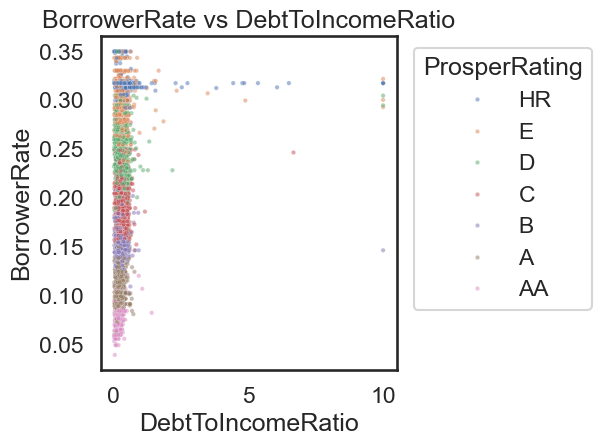

In [5]:
if 'DebtToIncomeRatio' in df.columns:
    fig = plt.figure()
    samp2 = df[['DebtToIncomeRatio','BorrowerRate'] + (['ProsperRating_Alpha'] if 'ProsperRating_Alpha' in df.columns else [])].dropna().sample(min(8000, df.dropna().shape[0]), random_state=21)
    if 'ProsperRating_Alpha' in samp2.columns:
        sns.scatterplot(data=samp2, x='DebtToIncomeRatio', y='BorrowerRate', hue='ProsperRating_Alpha', s=10, alpha=0.5)
        plt.legend(title="ProsperRating", bbox_to_anchor=(1.02,1), loc="upper left")
    else:
        plt.scatter(samp2['DebtToIncomeRatio'], samp2['BorrowerRate'], s=10, alpha=0.5)
    plt.title("BorrowerRate vs DebtToIncomeRatio")
    plt.xlabel("DebtToIncomeRatio")
    plt.ylabel("BorrowerRate")
    plt.tight_layout()
    plt.show()


**Takeaway:** زيادة DTI غالبًا مرتبطة بمعدلات أعلى، مع تباين بحسب التقييم.

## 6. Conclusions
- **العامل الأهم:** جودة المقترض (ProsperRating/Score) + خصائص المخاطرة (DTI) تؤثر بقوة على BorrowerRate.
- **تداخل العوامل:** عند ضبط المبلغ، يظهر أثر التقييم بوضوح؛ وعند ضبط التقييم، يظهر أثر DTI.
- **اقتراحات متابعة:** تحويلات لوغ، ونماذج انحدار متعددة المتغيرات لقياس الأثر الهامشي بدقة.

## 7. Export Instructions
من Jupyter اختاري **File → Download as → HTML (.html)** أو PDF لرفع النتيجة النهائية.